# libs

In [62]:
import warnings
import numpy as np 
import pandas as pd

import klib as kb
import seaborn as sns
import missingno  as msno
import plotly.express as px
import matplotlib.pyplot as plt

from collections import defaultdict
from librosa.display import specshow

from extract_mir import(
    table_missing, 
    play_audio, 
    load_data
)

from sklearn.preprocessing import ( 
    LabelEncoder,
    minmax_scale
)

from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score
)

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.feature_selection import RFECV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Import Data

In [3]:
df = load_data('df_vozes.aulas')
df['classes'] = [df.file_name[i][-5] for i in range(len(df.file_name))]
df['classes'] = df['classes'].astype(int)
df.head()

,genre,file_name,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,chroma8,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,classes
0,man,masc_leandro_03.wav,0.532917,0.467203,0.446371,0.530192,0.525608,0.508422,0.551480,0.488027,...,-4.280902,4.075489,-1.491291,-1.313429,-0.096837,1.237318,-1.021876,2.909949,-1.890091,3
1,man,masc_leandro_02.wav,0.458964,0.483202,0.508762,0.548762,0.470810,0.525118,0.554583,0.544027,...,-5.984279,1.940785,-1.865200,-1.280384,-3.052951,2.050714,-3.150480,-0.345990,-1.549047,2
2,man,masc_leandro_00.wav,0.742769,0.773986,0.820261,0.595191,0.211239,0.191502,0.250498,0.327664,...,-3.029799,1.445560,-0.906529,0.003409,-1.588059,-0.261001,-0.446271,0.733066,-1.092112,0
3,man,masc_leandro_01.wav,0.644371,0.713289,0.802725,0.756224,0.376040,0.180759,0.254233,0.314618,...,-3.077597,1.287589,-1.537610,-1.230811,-2.145245,-1.232941,-0.319495,1.539258,-0.691343,1
4,man,masc_leandro_04.wav,0.645344,0.709746,0.749380,0.721247,0.350555,0.286756,0.284837,0.287571,...,-2.594415,1.009358,-2.966235,0.092398,-0.465028,0.572403,-0.384600,1.306111,-0.316527,4


# Visualização de dados

### Boxplot

- Tonnetz

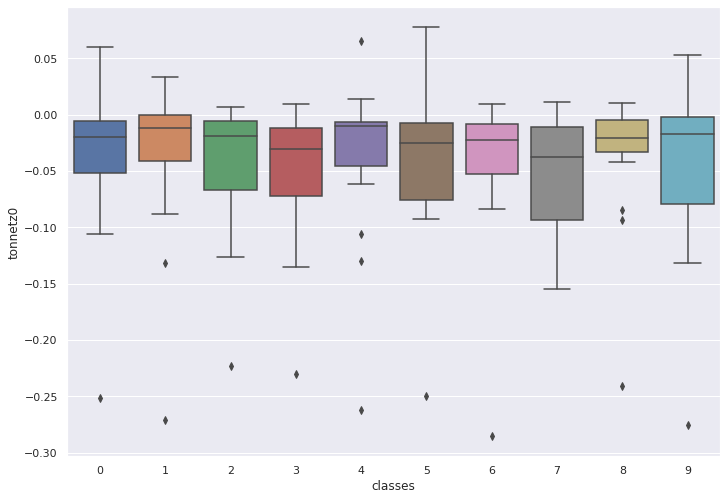

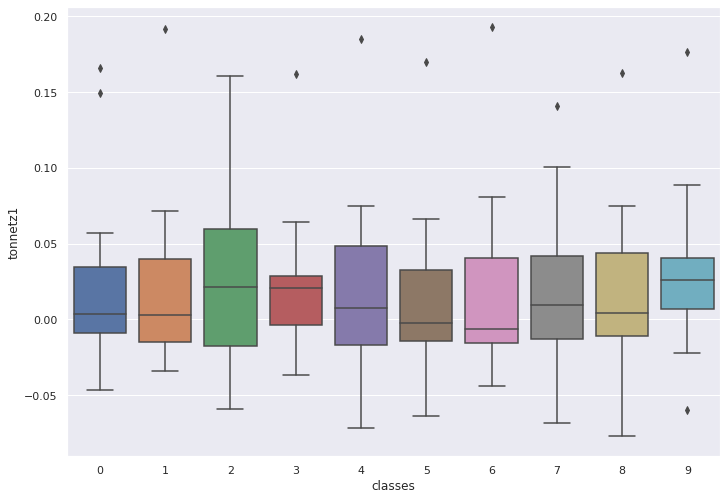

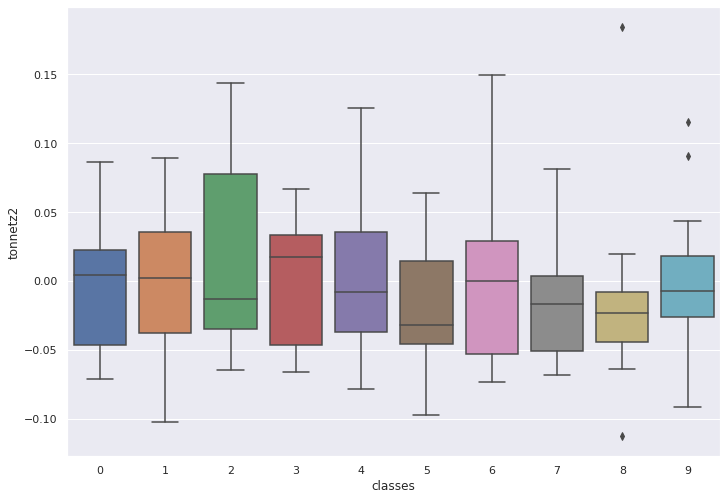

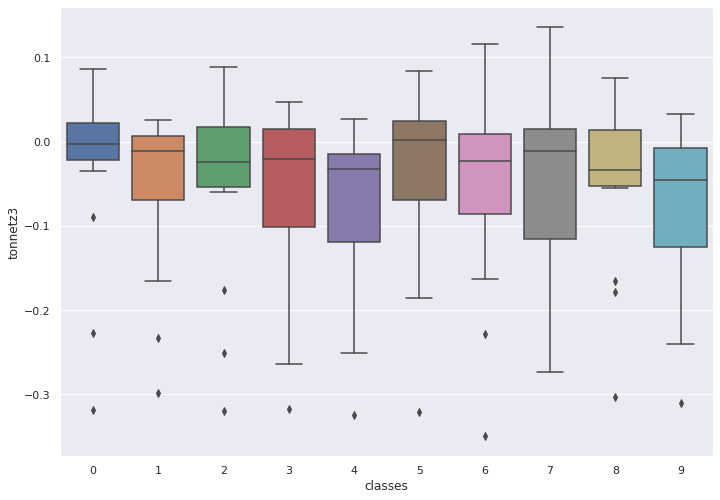

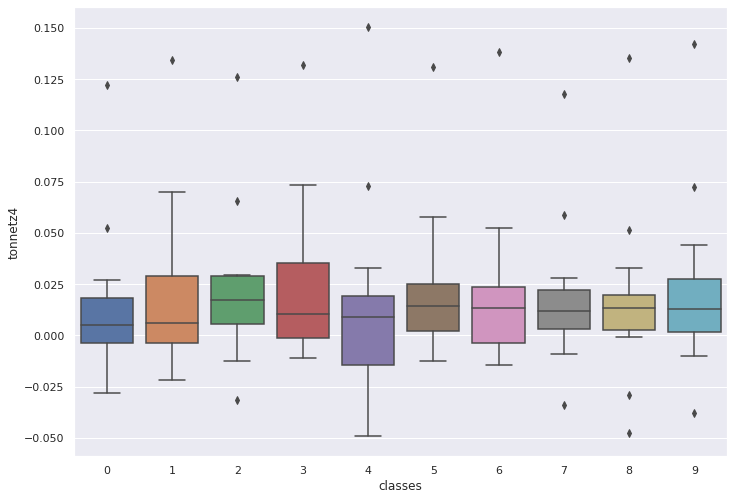

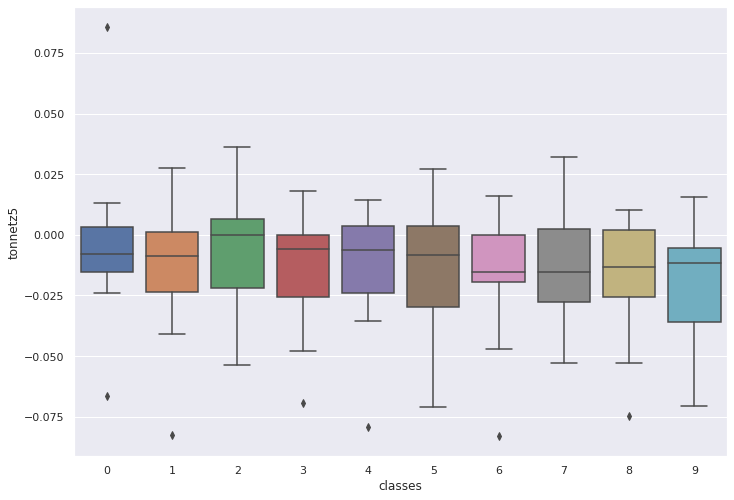

In [13]:
for i in range(6):
    ax = sns.boxplot(x="classes", y=f'tonnetz{i}', data=df)
    plt.show()

- Chromograma

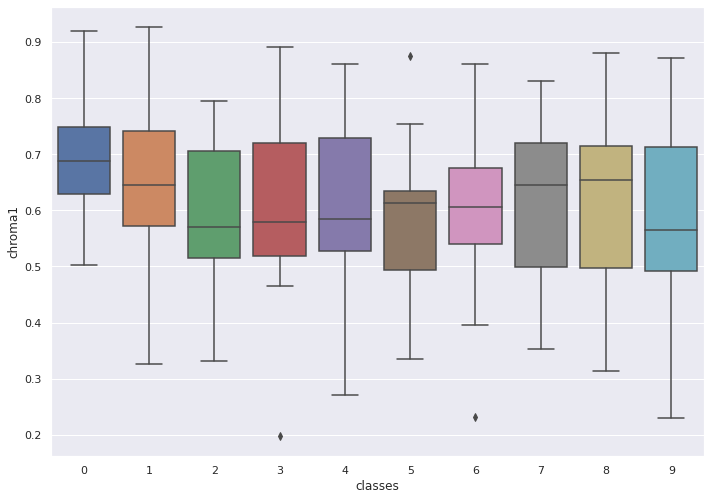

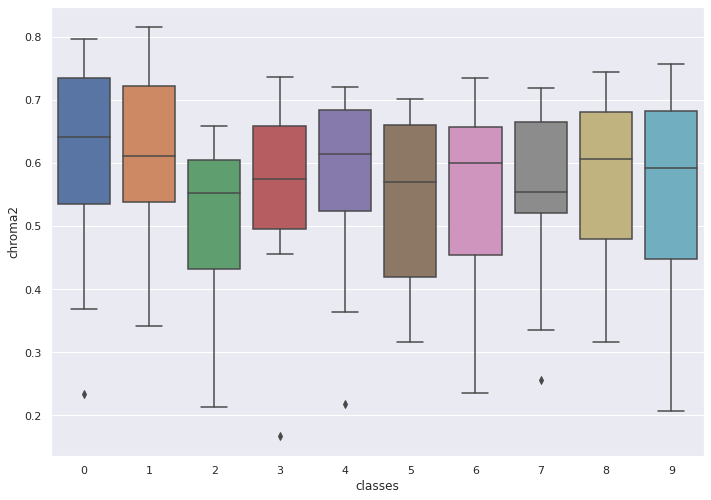

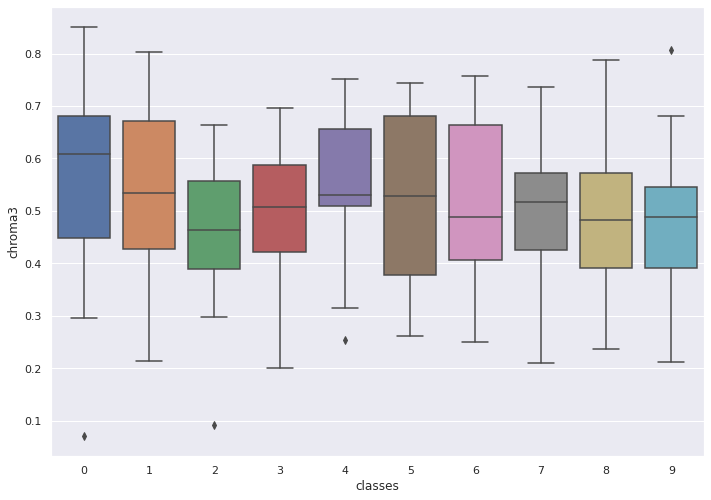

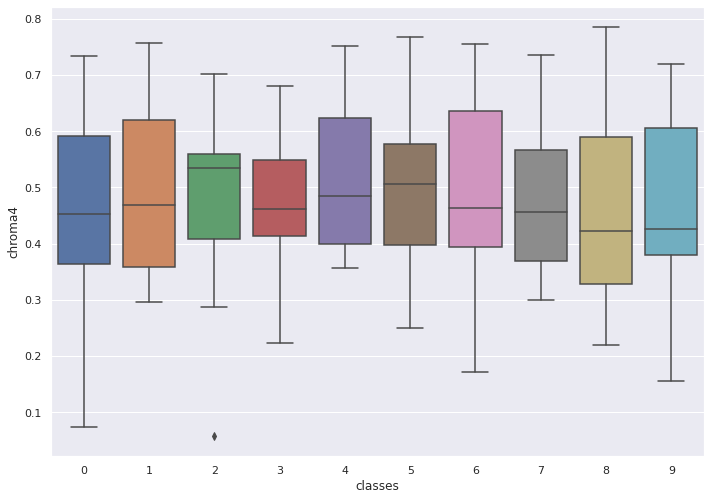

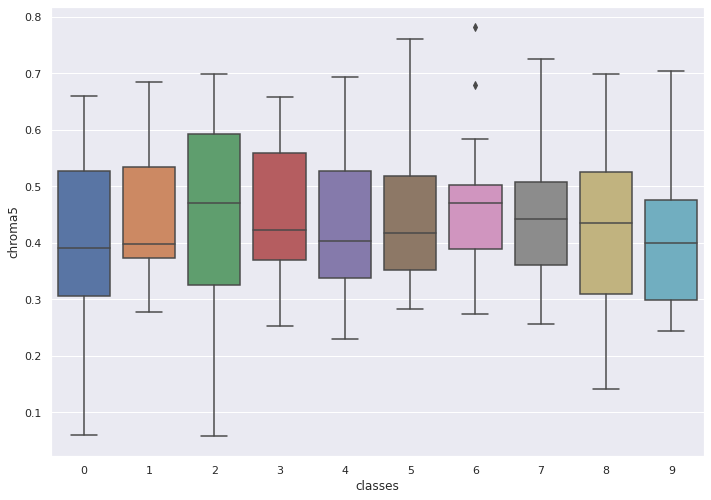

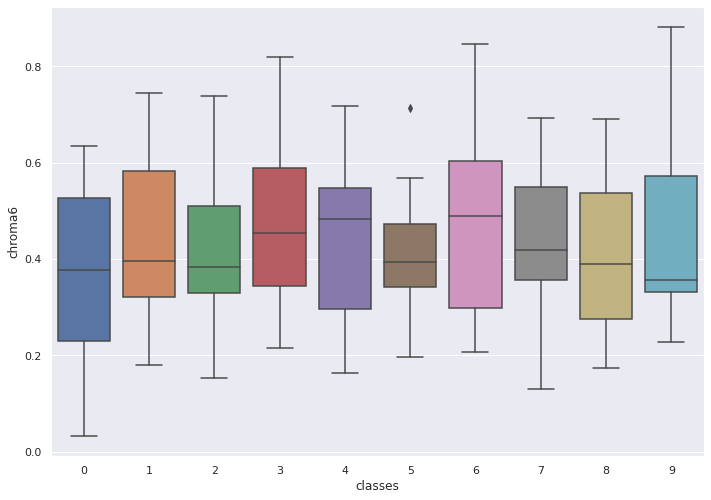

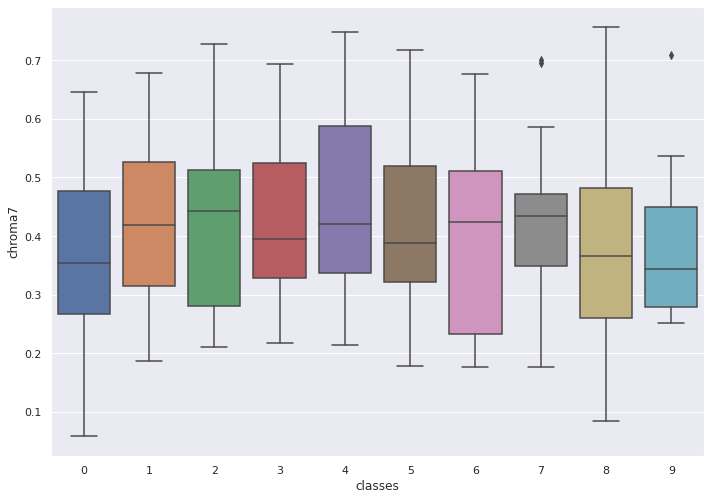

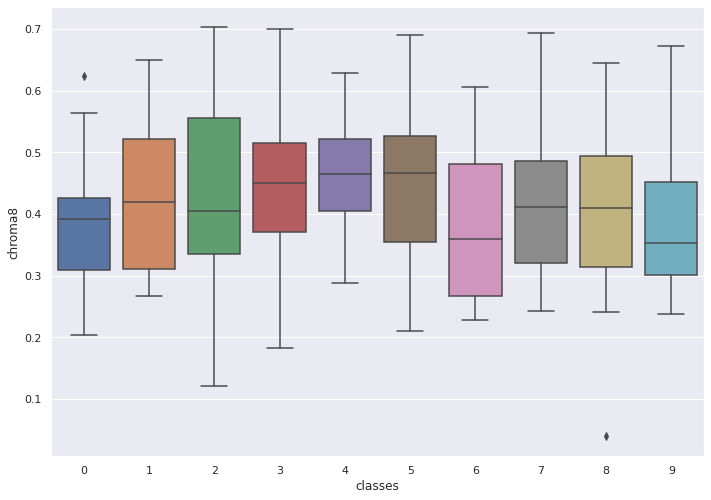

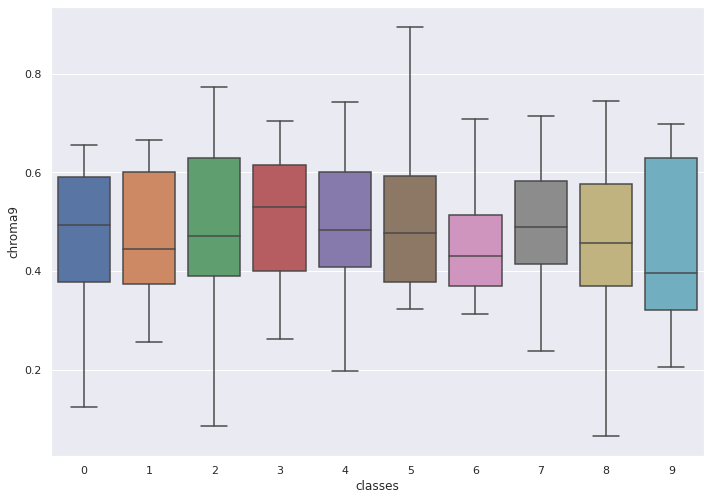

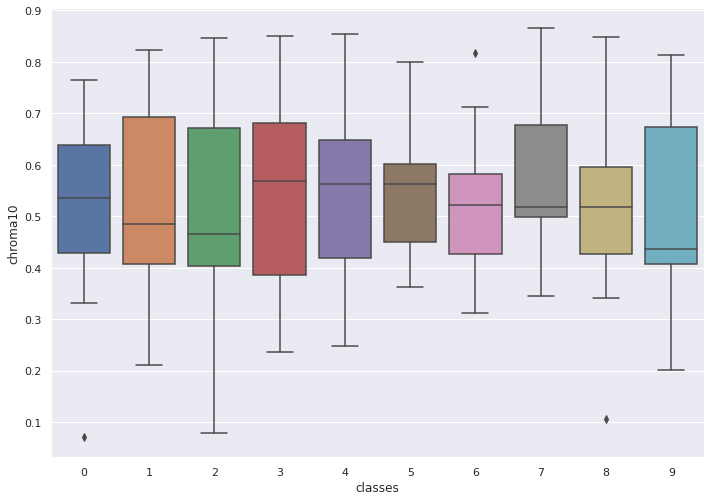

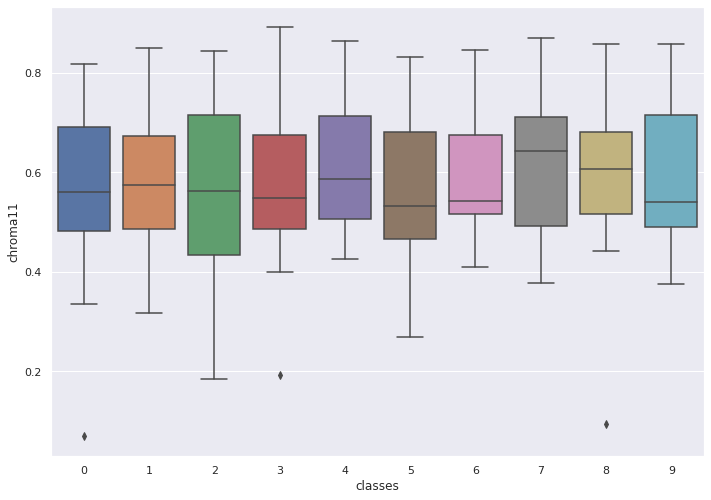

In [4]:
for i in range(1, 12):
    ax = sns.boxplot(x="classes", y=f'chroma{i}', data=df)
    plt.show()

- MFCC

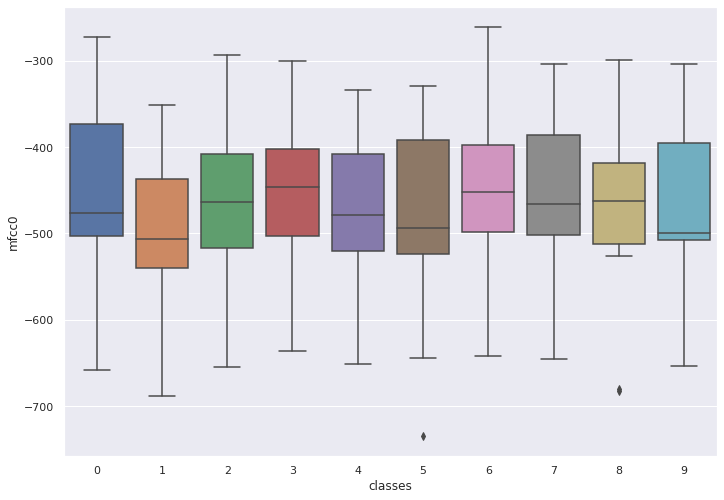

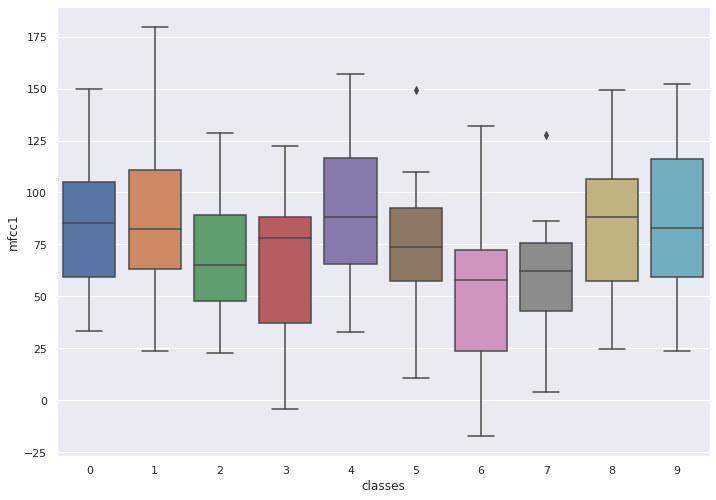

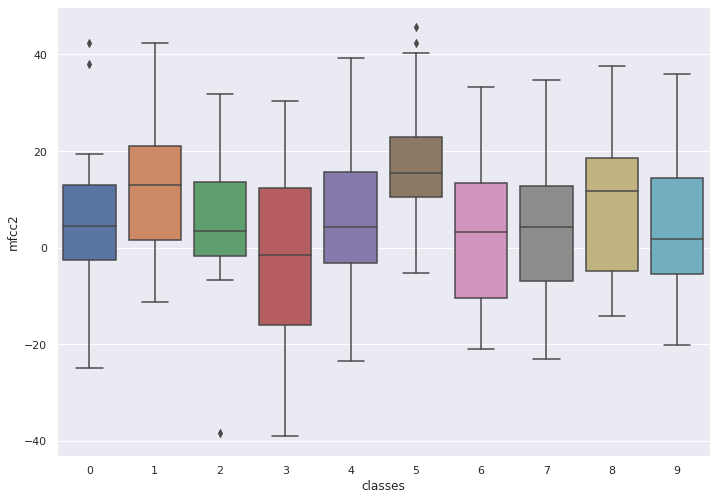

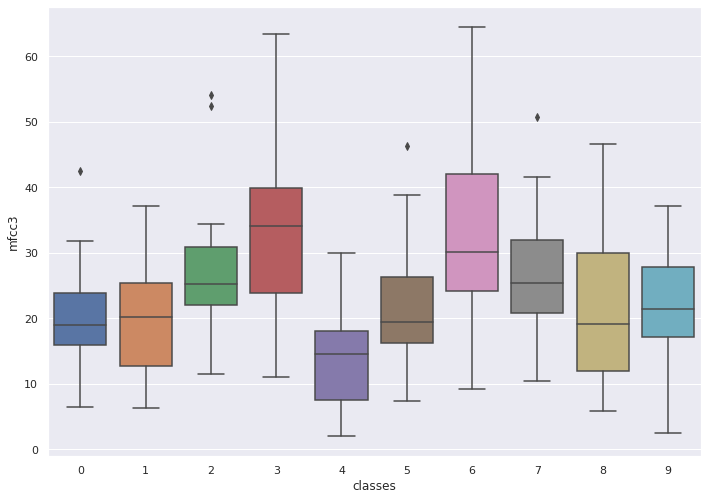

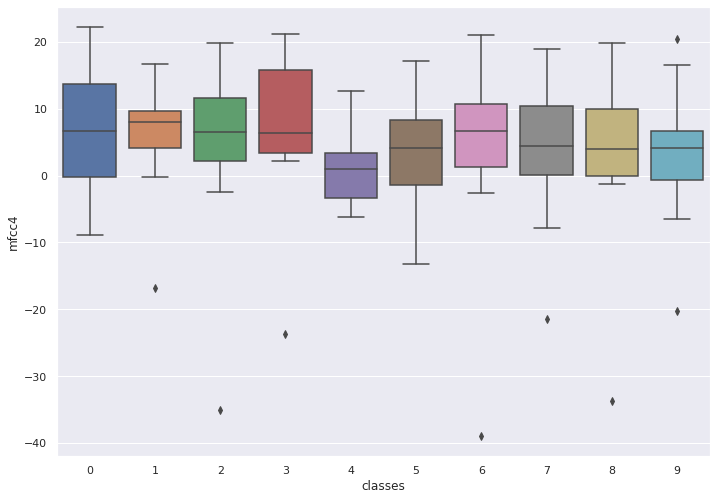

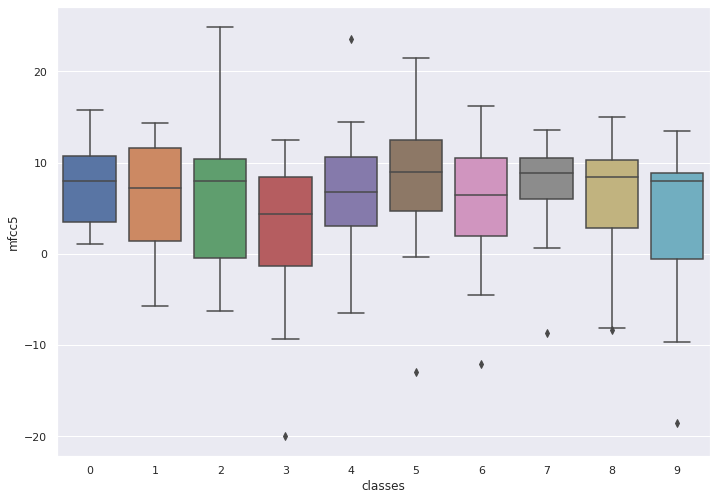

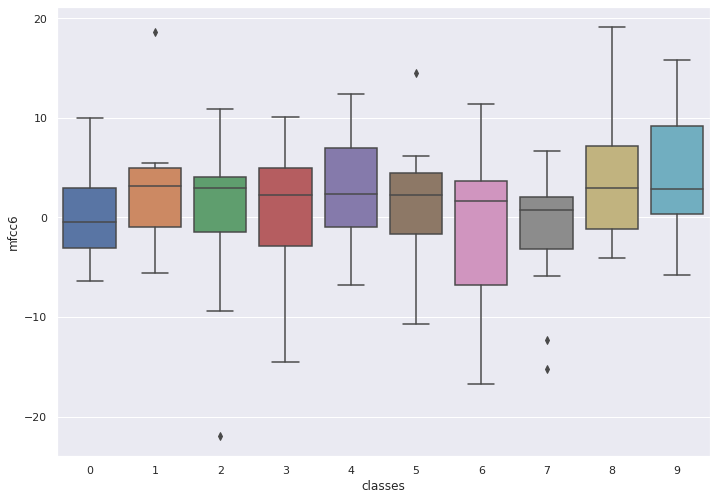

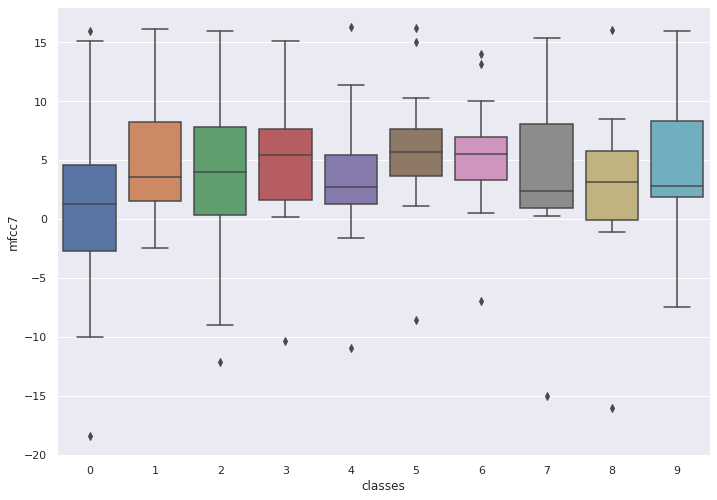

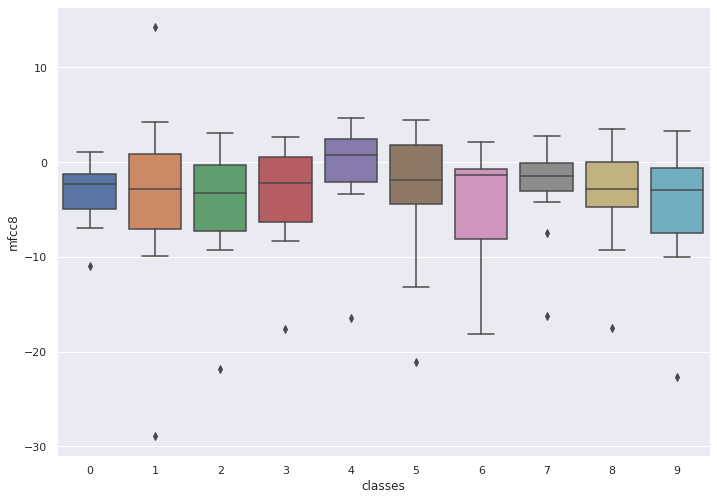

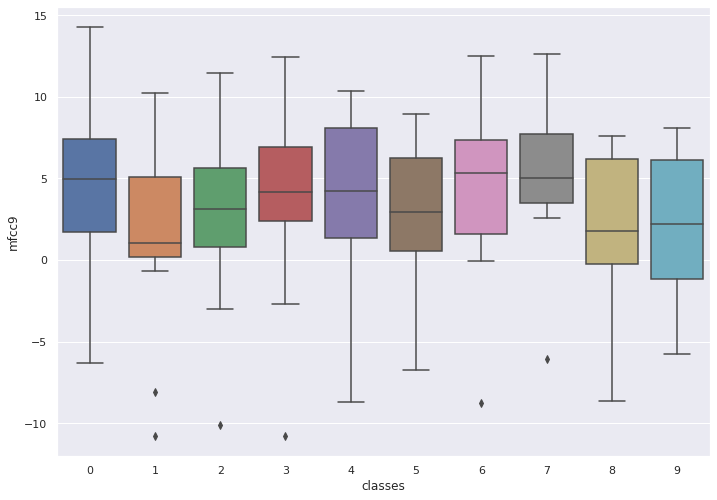

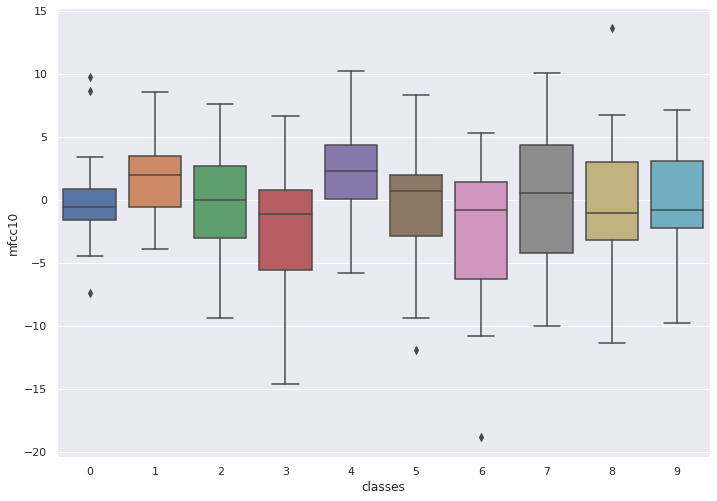

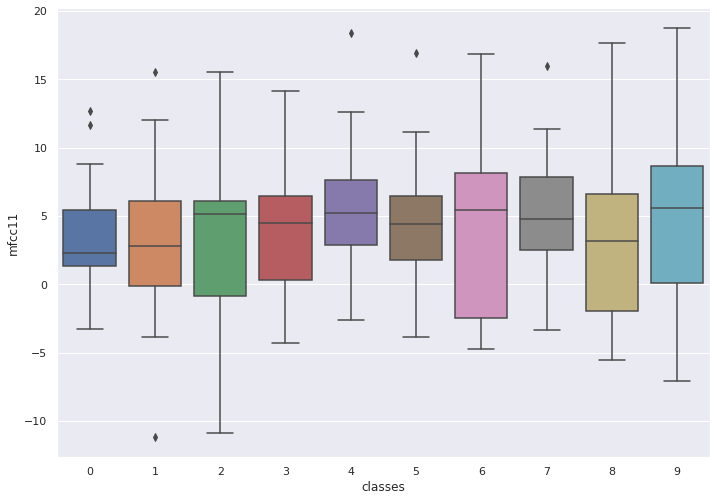

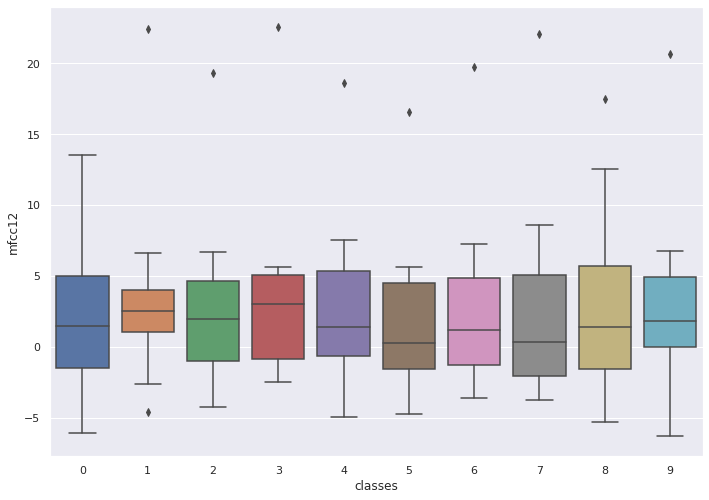

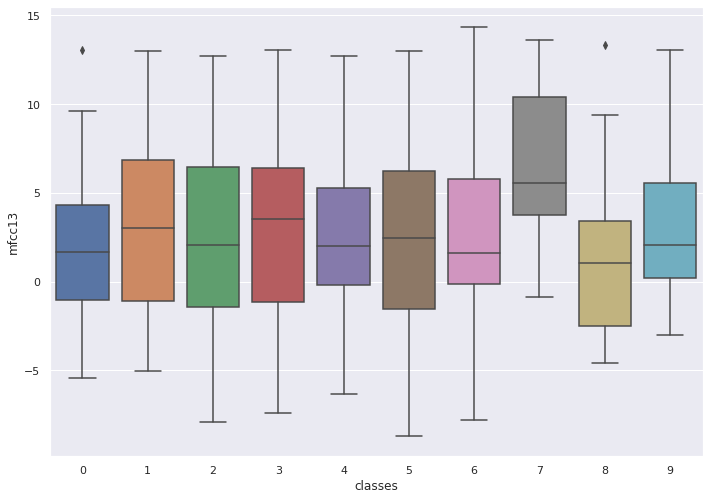

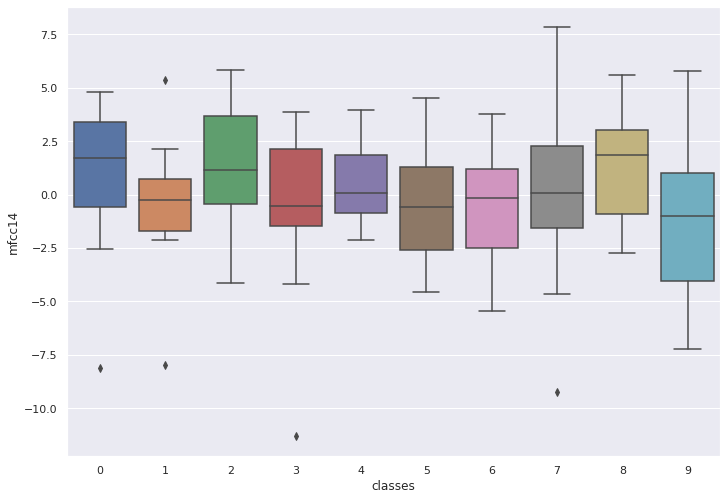

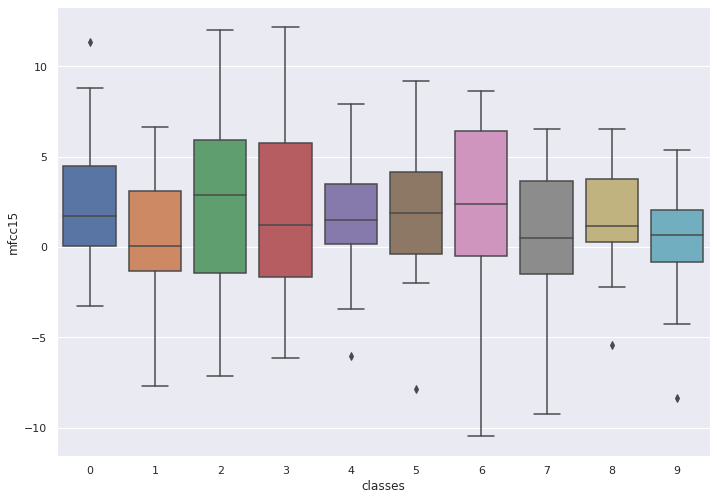

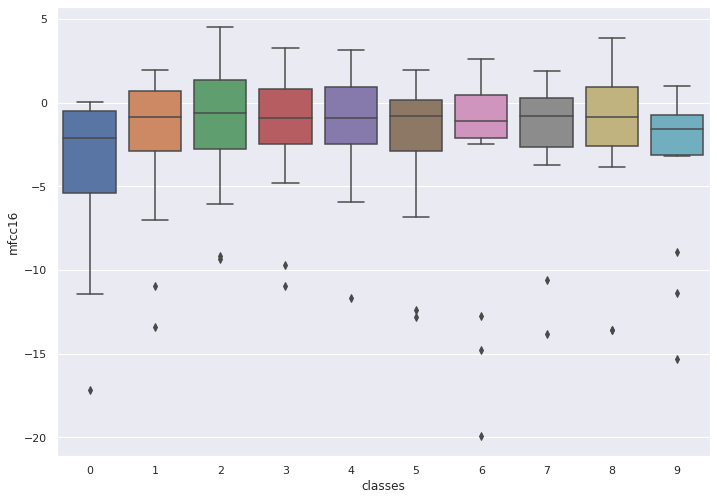

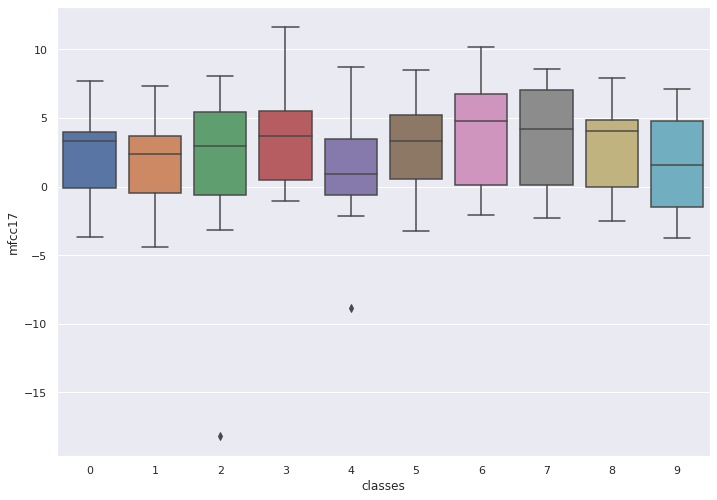

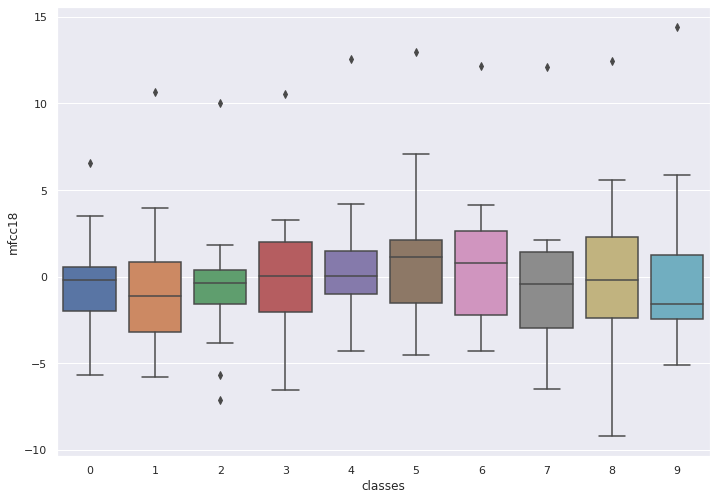

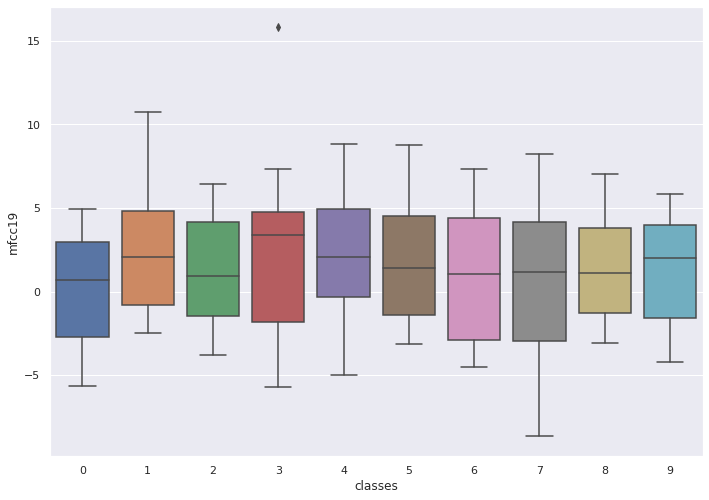

In [5]:
for i in range(20):
    ax = sns.boxplot(x="classes", y=f'mfcc{i}', data=df)
    plt.show()

### Vamos olhar o tempo BPM para cada numero

In [ ]:
ax = sns.barplot(x="classes", y="tempo_bpm", data=df)

### Plot do Zero crossing rate de cada digito

In [ ]:
for i in range(10):
    plt.title(f'Zero Crossing Rate de {i}')
    plt.plot(df[df['classes'] == i]['zero_crossing_rate'], color = '#FFB100')
    plt.show()

### Plot do Zero crossings de cada digito

In [ ]:
for i in range(10):
    plt.title(f'zero crossings de {i}')
    plt.plot(df[df['classes'] == i]['zero_crossing'], color = '#FFB100')
    plt.show()

### Plot do harmonico de cada digito

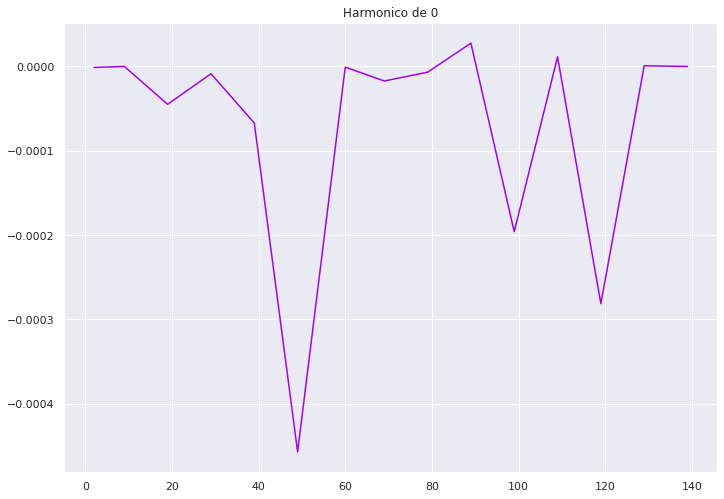

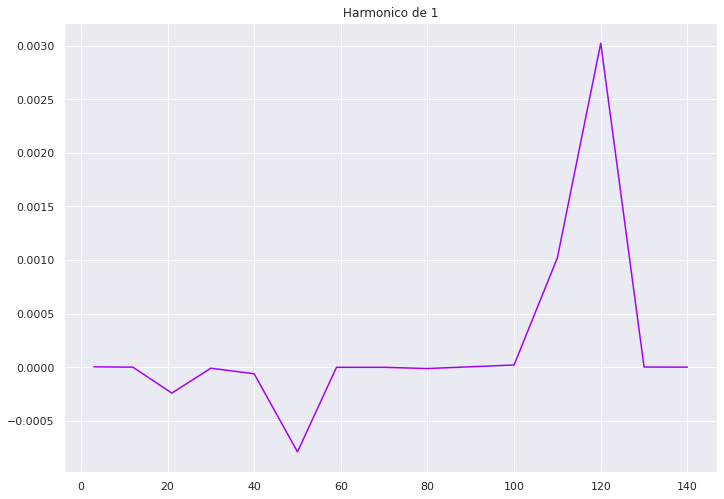

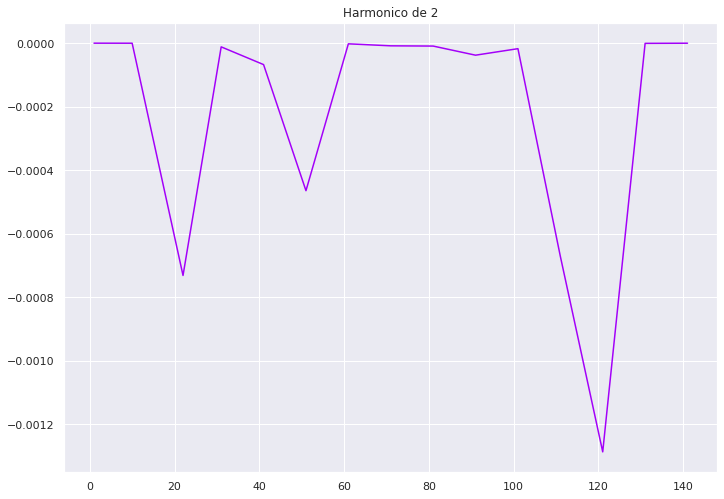

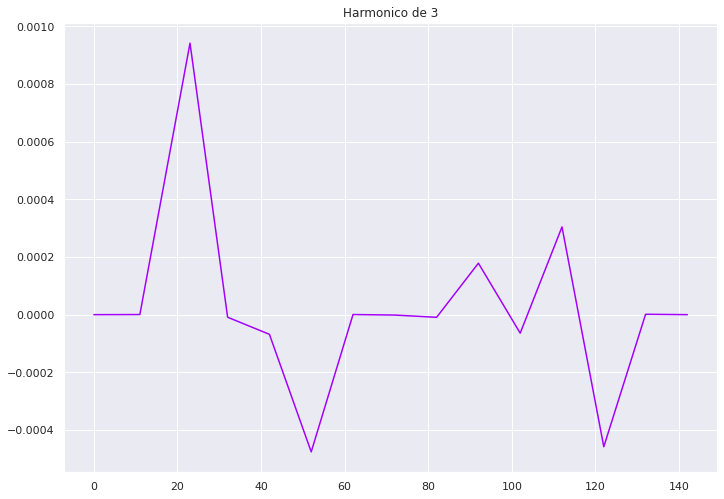

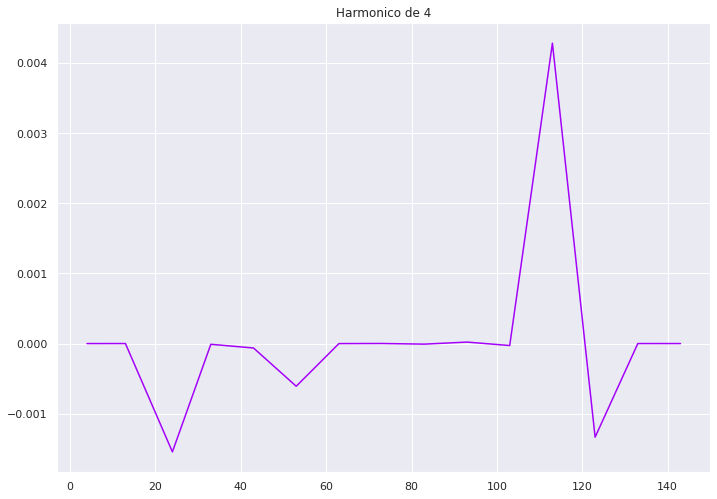

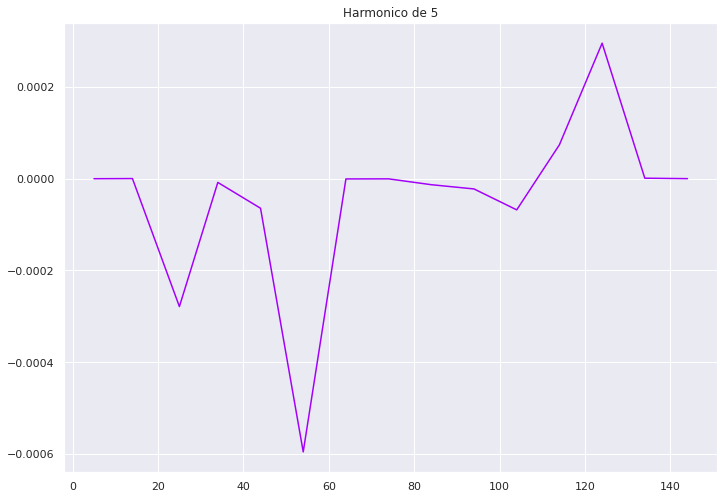

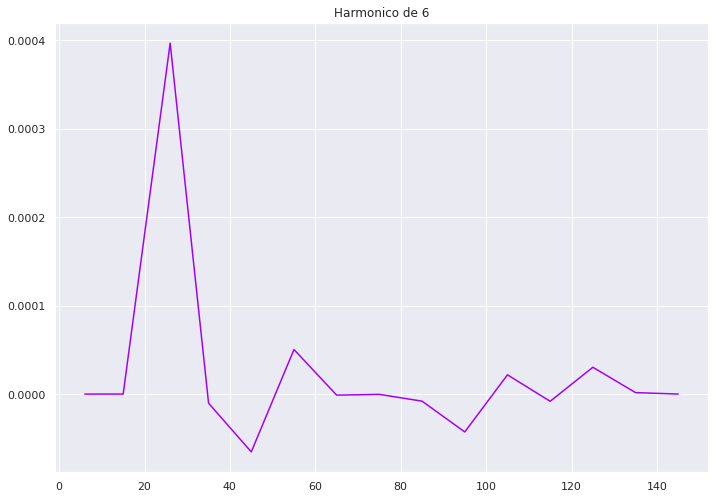

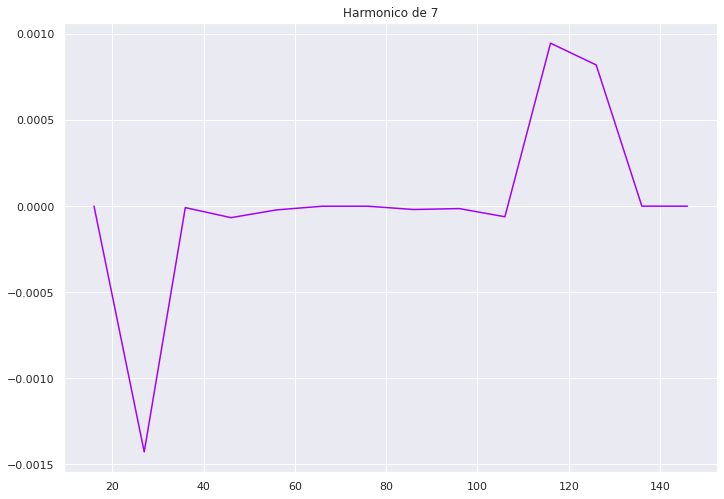

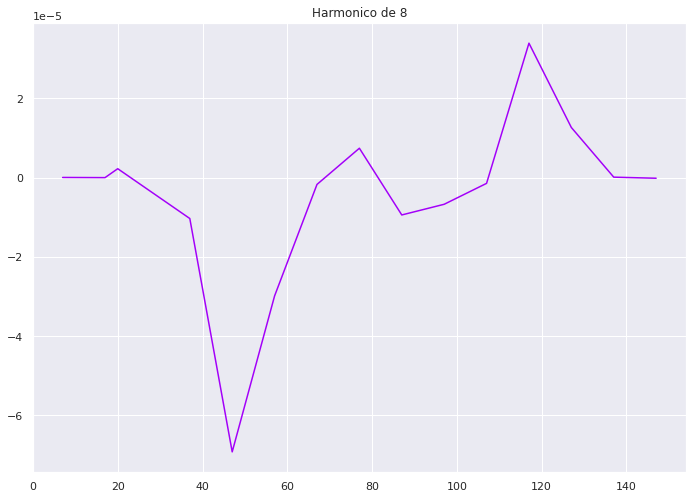

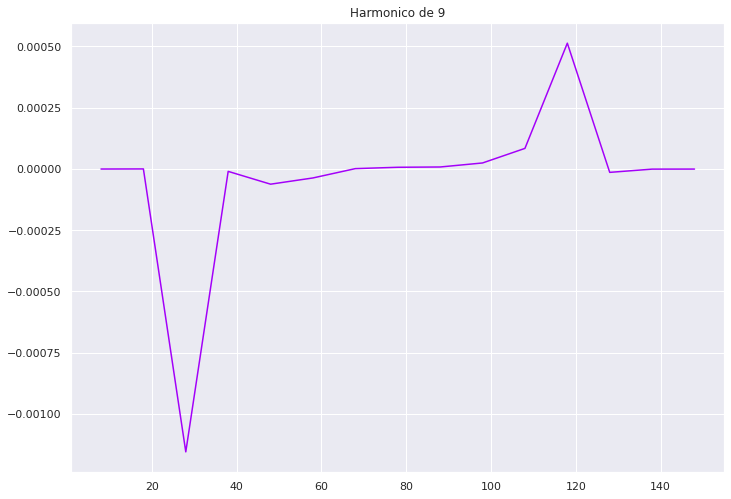

In [15]:
for i in range(10):
    plt.title(f'Harmonico de {i}')
    plt.plot(df[df['classes'] == i]['harmonics'], color = '#A300F9')
    plt.show()

### Plot de distribuição das features

Note: The number of non binary numerical features is very large (52), please consider splitting the data. Showing plots for the first 20 numerical features. Override this by setting showall=True.


<AxesSubplot:xlabel='spectral_rolloff', ylabel='Density'>

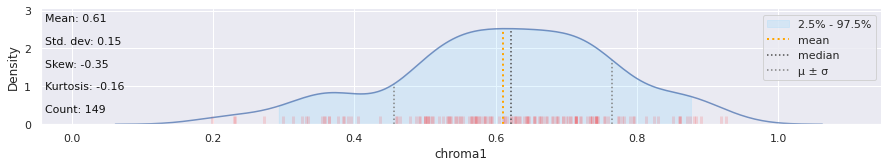

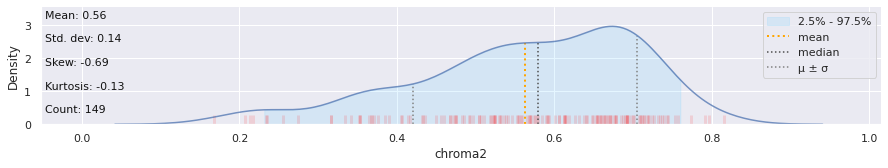

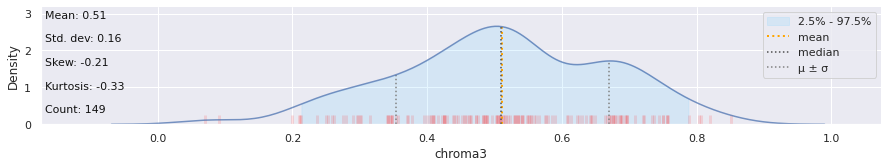

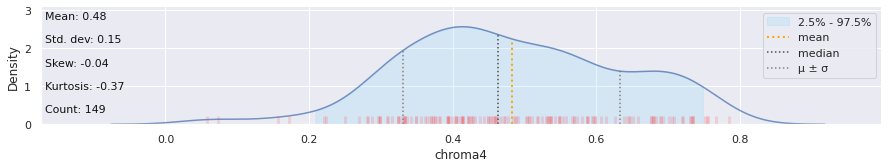

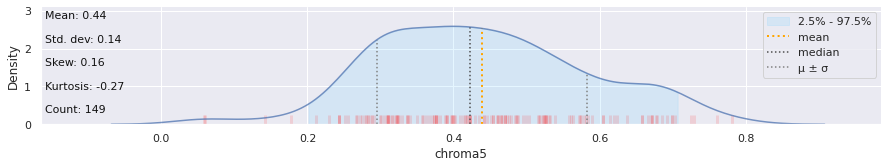

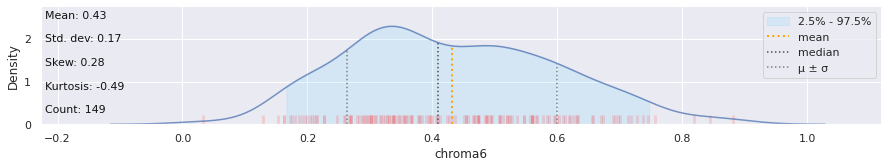

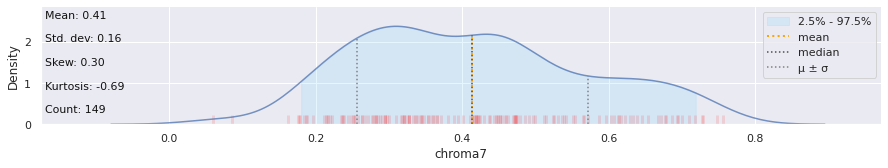

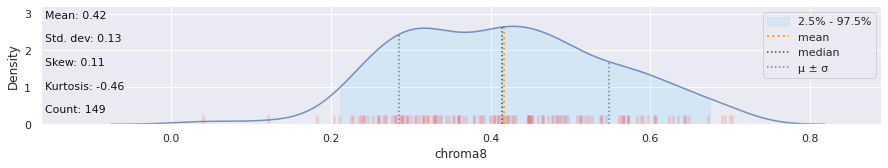

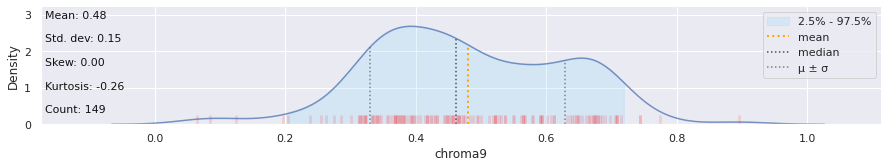

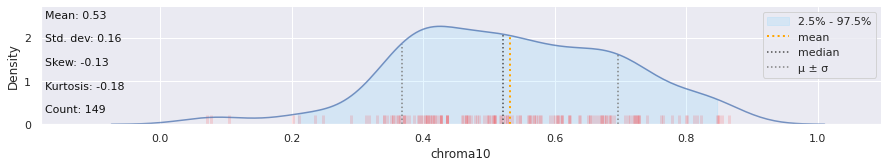

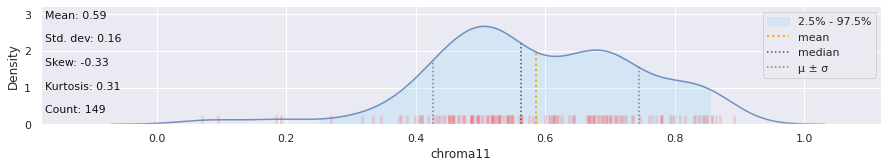

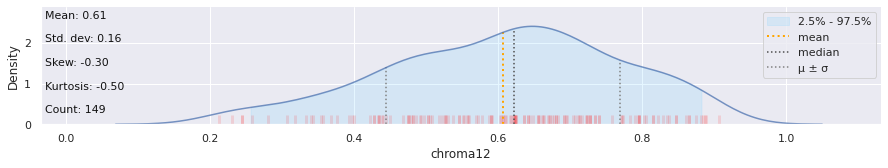

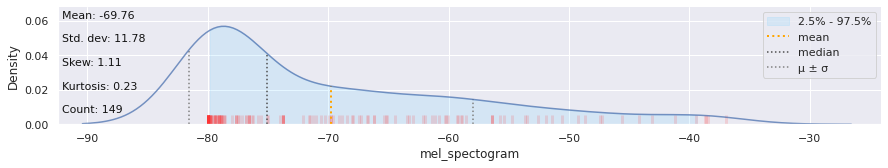

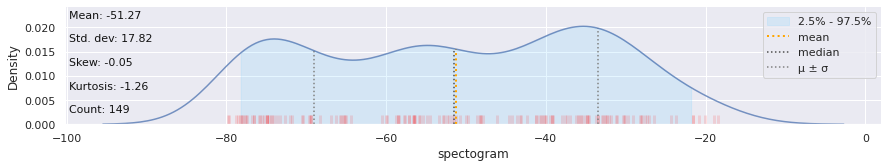

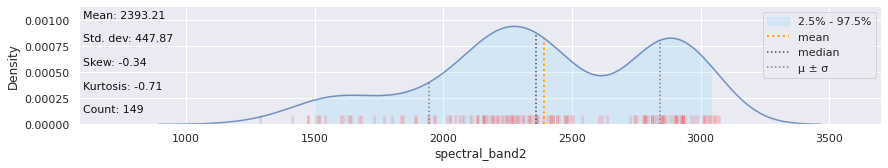

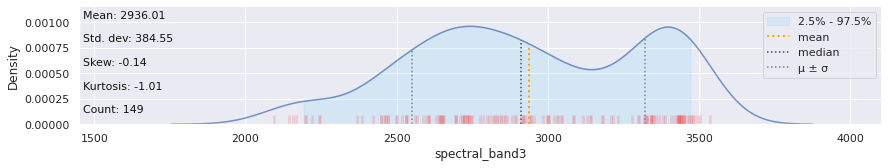

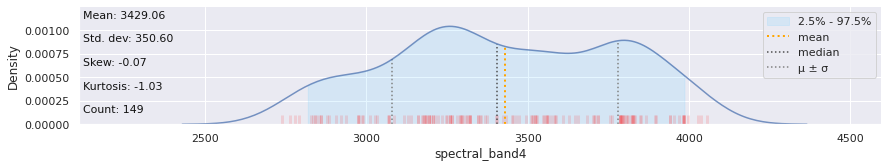

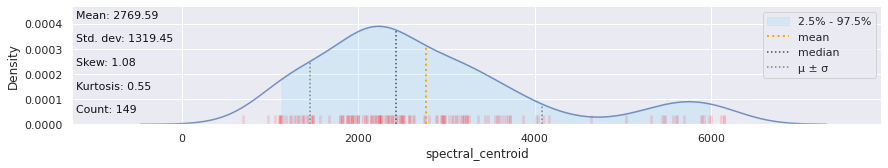

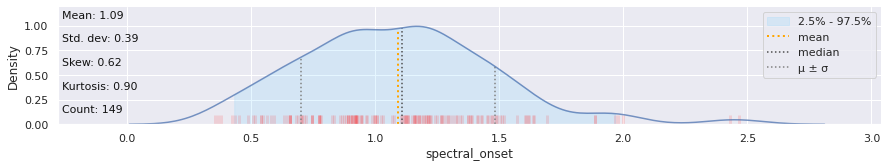

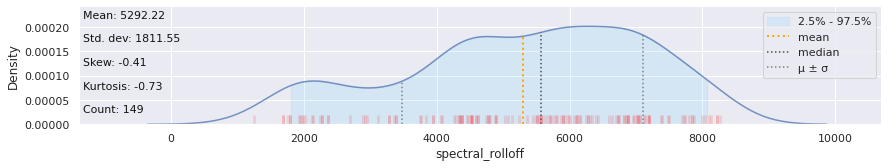

In [11]:
kb.dist_plot(df)

### Colunas selecionadas

In [25]:
features = [
    'chroma3', 'chroma4', 'chroma5', 'chroma6', 'chroma7', 'tempo_bpm',
    'chroma8', 'chroma9', 'chroma10','chroma11', 'chroma12', 'mfcc0', 
    'mfcc1', 'mfcc2', 'mfcc3',  'mfcc7', 'mfcc9', 'mfcc10', 'mfcc11',
    'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15','mfcc18', 'mfcc19', 'tonnetz2',
    'tonnetz1', 'spectral_centroid', 'spectral_onset', 'spectral_rolloff', 
    'harmonics','perceptual', 'tempo_bpm', 'zero_crossing_rate', 'zero_crossing','classes'
]

In [26]:
df[features]

,chroma3,chroma4,chroma5,chroma6,chroma7,tempo_bpm,chroma8,chroma9,chroma10,chroma11,...,tonnetz1,spectral_centroid,spectral_onset,spectral_rolloff,harmonics,perceptual,tempo_bpm,zero_crossing_rate,zero_crossing,classes
0,0.446371,0.530192,0.525608,0.508422,0.551480,112.347147,0.488027,0.530164,0.604359,0.664651,...,0.021313,1924.680501,0.541166,3833.554863,-3.915049e-07,-9.539572e-06,112.347147,0.089718,7701,3
1,0.508762,0.548762,0.470810,0.525118,0.554583,161.499023,0.544027,0.565009,0.542226,0.563079,...,0.022087,3231.975334,0.487582,6883.530245,1.807200e-07,1.439625e-05,161.499023,0.191793,17060,2
2,0.820261,0.595191,0.211239,0.191502,0.250498,258.398438,0.327664,0.432139,0.530443,0.607261,...,-0.009254,5999.259360,0.423338,8094.869385,-1.236870e-06,-3.026970e-05,258.398438,0.592334,48814,0
3,0.802725,0.756224,0.376040,0.180759,0.254233,184.570312,0.314618,0.368128,0.410647,0.486727,...,0.014324,6148.065789,0.353351,8217.209236,3.108951e-06,5.610282e-05,184.570312,0.610556,48744,1
4,0.749380,0.721247,0.350555,0.286756,0.284837,112.347147,0.287571,0.371092,0.468216,0.550973,...,0.013107,5617.867372,0.516118,7476.866455,-2.958416e-07,-2.462635e-05,112.347147,0.557781,40262,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.348221,0.349596,0.375937,0.393960,0.356796,129.199219,0.360932,0.476208,0.571880,0.717184,...,-0.064017,2503.197135,1.159487,6073.191481,-1.706724e-07,-1.049166e-05,129.199219,0.092965,6240,5
145,0.348056,0.393183,0.451203,0.465132,0.424618,151.999081,0.387472,0.466791,0.558990,0.685666,...,-0.009684,2883.267743,1.206278,6642.247784,3.226374e-08,-4.942891e-06,151.999081,0.128125,8595,6
146,0.342419,0.380696,0.428949,0.411884,0.365440,143.554688,0.322941,0.452103,0.497066,0.668623,...,-0.037436,2968.256189,1.383463,6697.405912,-4.112958e-07,-5.946017e-06,143.554688,0.133436,8956,7
147,0.236452,0.280400,0.372836,0.436785,0.365410,172.265625,0.294046,0.418696,0.518494,0.616374,...,-0.013670,2480.714807,1.247829,6116.589168,-1.610732e-07,5.608899e-07,172.265625,0.095790,6427,8


### Correlação

- Correlação Negativa

Displaying negative correlations. Specify a negative "threshold" to limit the results further.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

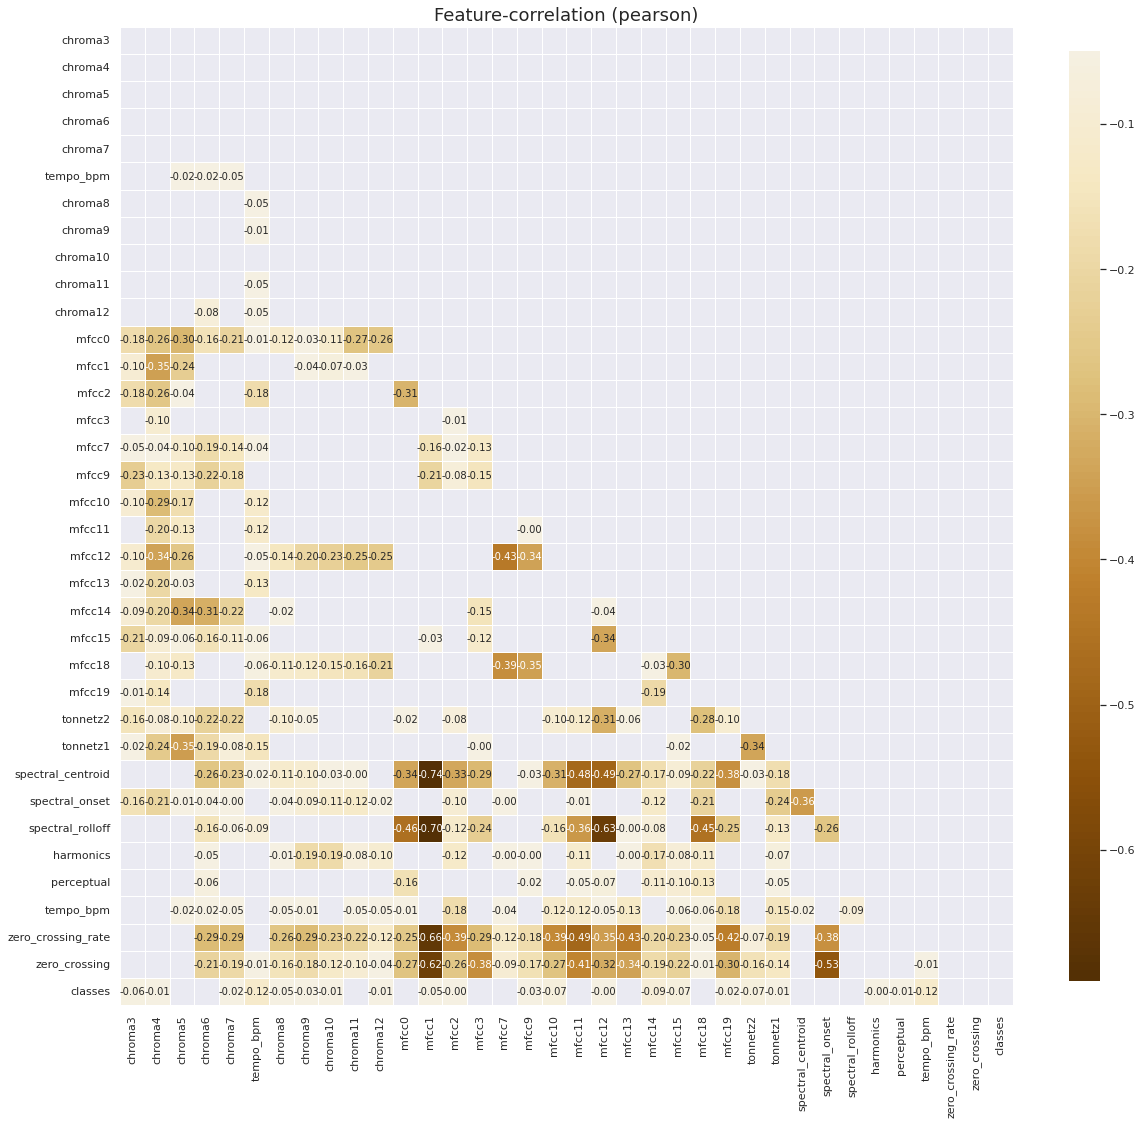

In [35]:
kb.corr_plot(df[features], split='neg', figsize=(20,18))

- Correlação Positiva

Displaying positive correlations. Specify a positive "threshold" to limit the results further.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

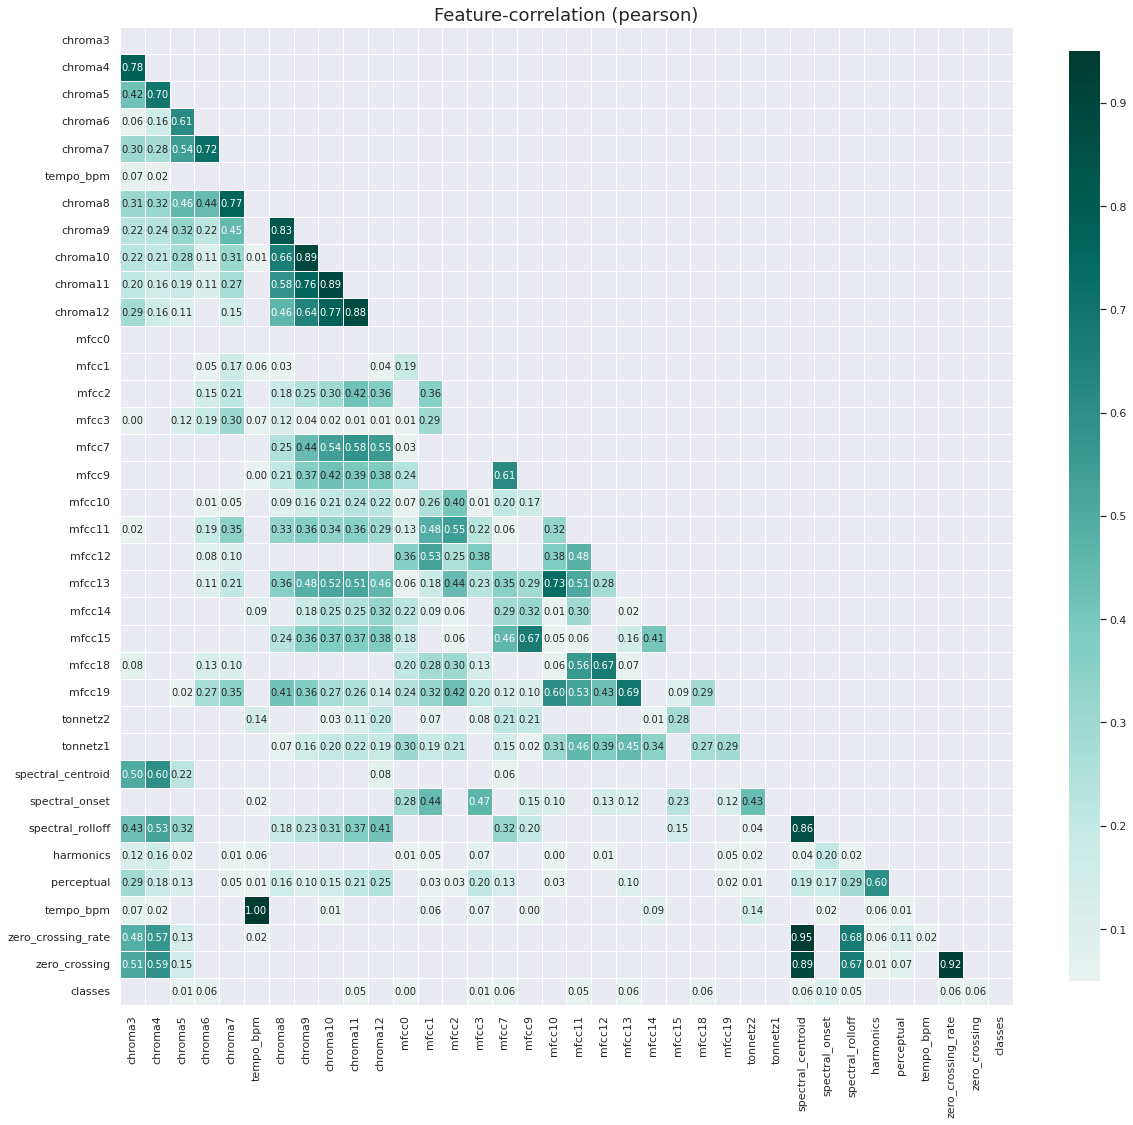

In [34]:
kb.corr_plot(df[features], split='pos', figsize=(20,18))

# Modelagem

- Definindo X e y 

In [49]:
X = df[features[:-1]]
y = df["classes"]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Teste 1

- Arvore de decisão

In [50]:
score = cross_val_score(DecisionTreeClassifier(), X, y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: 7.000000000000001%


- Random Forest

In [51]:
score = cross_val_score(RandomForestClassifier(), X, y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: 4.0%


- Regressão Logistica

In [52]:
score = cross_val_score(LogisticRegression(), X, y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: 11.0%


- knn

In [53]:
select_k = defaultdict(list)

for i in range(1, 100):
    score = cross_val_score(KNeighborsClassifier(n_neighbors=i), X, y, cv=kfold, scoring="accuracy")
    
    select_k['k'].append(i)
    select_k['acuracia'].append(round(np.mean(score), 2) * 100)

df_select_k = pd.DataFrame(select_k)
df_select_k.sort_values(by='acuracia', ascending=False)

,k,acuracia
98,99,9.0
92,93,9.0
97,98,9.0
77,78,9.0
95,96,9.0
...,...,...
33,34,3.0
19,20,3.0
11,12,3.0
8,9,2.0


- XGBoost

In [63]:
score = cross_val_score(XGBClassifier(), X, y,  scoring='accuracy', cv=kfold)

In [59]:
score

array([nan, nan, nan, nan, nan])

In [57]:
print(f'score: {round(np.mean(score), 2) * 100}%')

score: nan%


- LithGBM

In [60]:
score = cross_val_score(LGBMClassifier(), X, y, scoring='accuracy', cv=kfold)
print(f'score: {round(np.mean(score), 2) * 100}%')

[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.
[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.
[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.


score: nan%


[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.
[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.


### Teste 2

- Normalização de features

In [66]:
X_norm = minmax_scale(X)

- Regressão Logitica

In [68]:
score = cross_val_score(LogisticRegression(), X_norm, y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: 11.0%


- KNN

In [69]:
select_k = defaultdict(list)

for i in range(1, 100):
    score = cross_val_score(KNeighborsClassifier(n_neighbors=i), X_norm, y, cv=kfold, scoring="accuracy")
    
    select_k['k'].append(i)
    select_k['acuracia'].append(round(np.mean(score), 2) * 100)

df_select_k = pd.DataFrame(select_k)
df_select_k.sort_values(by='acuracia', ascending=False)

,k,acuracia
63,64,13.0
97,98,13.0
96,97,13.0
65,66,13.0
21,22,12.0
...,...,...
1,2,3.0
7,8,3.0
8,9,3.0
9,10,3.0


- Arvore de Decisão

In [70]:
score = cross_val_score(DecisionTreeClassifier(random_state=42), X_norm, y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: 7.000000000000001%


- LGBM

In [71]:
score = cross_val_score(LGBMClassifier(), X_norm, y, scoring='accuracy', cv=kfold)
print(f'score: {round(np.mean(score), 2) * 100}%')

score: 9.0%


- Random Forest

In [88]:
score = cross_val_score(RandomForestClassifier(), X_norm, y, cv=kfold, scoring="accuracy")
print(f'score: {round(np.mean(score), 2) * 100}%')

score: 7.000000000000001%


# Tuning Hiperparamentros

- Arvore de Decisão

In [73]:
parametros = {
    "criterion": Categorical(['gini','entropy']),
    "max_depth": Integer(2, 17),
    "max_features": Categorical(['auto', 'sqrt', 'log2']),
    "min_samples_split": Integer(2, 10),
    "min_samples_leaf": Integer(1, 10)
    
}

decision_tree = DecisionTreeClassifier()

decision_tree_search = BayesSearchCV(
    decision_tree,
    parametros,
    n_iter=32,
    n_jobs=-1,
    cv=5,
    scoring='accuracy'
)

decision_tree_search.fit(X, y)

print(f'Acuracy: { decision_tree_search.best_score_ * 100}\n')
print(decision_tree_search.best_estimator_)
print(f'\n{ decision_tree_search.best_params_ }')

Acuracy: 21.448275862068968

DecisionTreeClassifier(max_depth=14, max_features='auto', min_samples_leaf=5,
                       min_samples_split=3)

OrderedDict([('criterion', 'gini'), ('max_depth', 14), ('max_features', 'auto'), ('min_samples_leaf', 5), ('min_samples_split', 3)])


- Random Foreste

In [74]:
parametros = {
    "criterion": Categorical(['gini','entropy']),
    "max_depth": Integer(6, 20),
    "min_samples_split": Integer(2, 10),
    "min_samples_leaf": Integer(2, 10),
    "max_features": Categorical(['auto', 'sqrt','log2']), 
    "bootstrap": Categorical([True, False]),
    "n_estimators": Integer(100, 500)
}

random_forest = RandomForestClassifier()

forest_bayes_search = BayesSearchCV(
    random_forest,
    parametros,
    n_iter=32,
    n_jobs=-1,
    cv=5,
    scoring='accuracy'
)

forest_bayes_search.fit(X, y)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=32, n_jobs=-1,
              scoring='accuracy',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=6, high=20, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('auto', 'sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize')})

In [76]:
print(f'Acuracy: { forest_bayes_search.best_score_ * 100}\n')
print(forest_bayes_search.best_estimator_)
print(f'\n{ forest_bayes_search.best_params_ }')

Acuracy: 26.82758620689655

RandomForestClassifier(max_depth=18, min_samples_leaf=3, min_samples_split=9,
                       n_estimators=312)

OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_depth', 18), ('max_features', 'auto'), ('min_samples_leaf', 3), ('min_samples_split', 9), ('n_estimators', 312)])


- MLP

In [ ]:
parametros = {
    'activation' : Categorical(['identity','logistic','tanh','relu']),
    'hidden_layer_sizes': Integer(20, 100)
}


mlp_bayes_search = BayesSearchCV(
    MLPClassifier(),
    parametros,
    n_iter=32,
    n_jobs=-1,
    cv=5,
    scoring='accuracy'
)

mlp_bayes_search.fit(X, y)

In [77]:
print(f'Acuracy: { mlp_bayes_search.best_score_ * 100}\n')
print(mlp_bayes_search.best_estimator_)
print(f'\n{ mlp_bayes_search.best_params_ }')

Acuracy: 16.114942528735632

MLPClassifier(activation='tanh', hidden_layer_sizes=33)

OrderedDict([('activation', 'tanh'), ('hidden_layer_sizes', 33)])


# Recursive Feature Elimination - (RFE)

### Teste 3

In [78]:
clf = DecisionTreeClassifier(max_depth=17,
                             max_features='auto', 
                             min_samples_leaf=2,
                             min_samples_split=3)
                               
estimators = RFECV(estimator=clf, scoring='accuracy')

# fit rfecv to data
rfecv_data = estimators.fit(X, y)

# get the feature ranking
ranking_features = rfecv_data.ranking_
# print(ranking_features)

support_features = rfecv_data.support_
# print(support_features)

In [79]:
rfecv_data.support_

array([False, False,  True, False, False,  True,  True, False,  True,
       False, False,  True, False,  True,  True,  True, False,  True,
        True, False, False,  True,  True, False, False, False,  True,
       False,  True, False, False,  True, False,  True, False])

In [80]:
features_selects = X.columns[support_features]

- Arvore de decisão

In [81]:
clf = DecisionTreeClassifier(max_depth=17,
                             max_features='auto', 
                             min_samples_leaf=2,
                             min_samples_split=3)

score = cross_val_score(clf, X[features_selects], y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: 9.0%


- knn

In [82]:
select_k = defaultdict(list)

for i in range(1, 100):
    score = cross_val_score(KNeighborsClassifier(n_neighbors=i), X[features_selects], y, cv=kfold, scoring="accuracy")
    
    select_k['k'].append(i)
    select_k['acuracia'].append(round(np.mean(score), 2) * 100)

df_select_k = pd.DataFrame(select_k)
df_select_k.sort_values(by='acuracia', ascending=False)

,k,acuracia
80,81,14.0
98,99,13.0
82,83,13.0
96,97,13.0
95,96,13.0
...,...,...
13,14,5.0
6,7,5.0
5,6,4.0
0,1,4.0


- LithGBM

In [83]:
score = cross_val_score(LGBMClassifier(), X[features_selects], y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: nan%


[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.
[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.
[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.
[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.
[LightGBM] [Fatal] Feature (tempo_bpm) appears more than one time.


- Random Forest

In [84]:
clf = RandomForestClassifier(
    bootstrap=False,
    criterion='gini',
    max_depth=20,
    max_features='auto',
    min_samples_split=2,
    min_samples_leaf=2,
    n_estimators=100
)

score = cross_val_score(clf, X[features_selects], y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: 8.0%


- XGBOOST

In [85]:
score = cross_val_score(XGBClassifier(), X[features_selects], y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: nan%


- MLP

In [86]:
mlp = MLPClassifier(hidden_layer_sizes=100, activation='relu')

score = cross_val_score(mlp, X[features_selects], y, cv=kfold, scoring="accuracy")
print(f'score: { round(np.mean(score), 2) * 100}%')

score: 9.0%
